In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

In [3]:
train_data.loc[train_data['reviewText'].isnull() & (train_data['sentiment'] == 'POSITIVE'), 'reviewText'] = 'good'
train_data.loc[train_data['reviewText'].isnull() & (train_data['sentiment'] == 'NEGATIVE'), 'reviewText'] = 'bad'
test_data.reviewText.fillna("",inplace=True)
print(test_data.shape,train_data.shape)
train_data.isna().sum()

(55315, 4) (162758, 5)


movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

In [4]:
train_data.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [5]:
test_data.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [6]:
# Summary statistics
train_data.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,162758,162758
unique,16812,4482,2,155073,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,good,POSITIVE
freq,708,962,113189,4042,108761


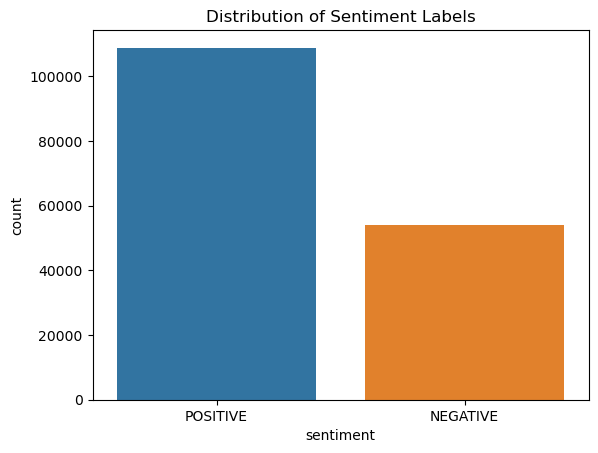

In [7]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_data)
plt.title("Distribution of Sentiment Labels")
plt.show()

INFERENCES : The number of Reviews that have positive reviews are almost twice than the negative reviews

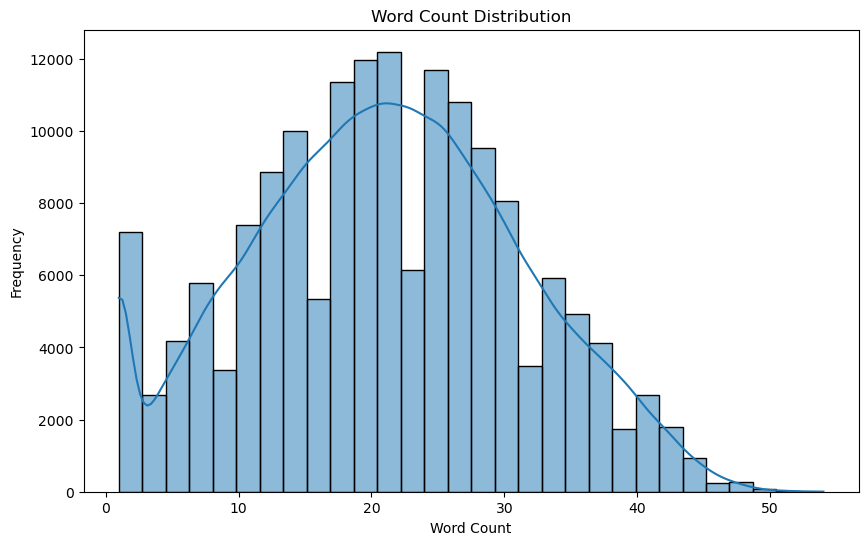

In [8]:
# Word count distribution
train_data['word_count'] = train_data['reviewText'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='word_count', bins=30, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

Inference : All the word count in every review against their frequency follow a gausian dist

In [9]:
# Average word count per sentiment
avg_word_count_per_sentiment = train_data.groupby('sentiment')['word_count'].mean()
print(avg_word_count_per_sentiment)

sentiment
NEGATIVE    20.470248
POSITIVE    21.283521
Name: word_count, dtype: float64


In [10]:
# Most common words (top N words)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=10)
word_matrix = cv.fit_transform(train_data['reviewText'])
word_freq = word_matrix.sum(axis=0)
words = cv.get_feature_names_out()
word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq.tolist()[0]})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
print(word_freq_df)

    word  frequency
3   film      26858
7  movie      18222
6   like      10955
4   good      10758
8  story       9411
1     46       8624
5   just       7332
0     44       7079
9   time       5775
2   best       5361


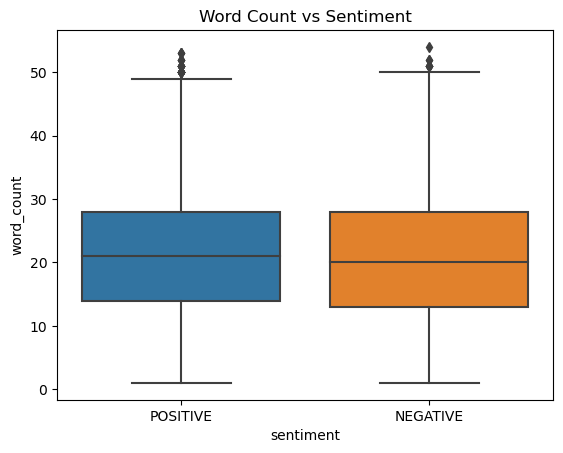

In [11]:
# Correlation between word count and sentiment
sns.boxplot(x='sentiment', y='word_count', data=train_data)
plt.title("Word Count vs Sentiment")
plt.show()

Inference : Both the Box Plots for the positive and negative sentiment have similar mean median . 

In [12]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Load data and preprocess as in your original code
train_sentiment=train_data['sentiment']
train_text=train_data['reviewText']
test = test_data['reviewText']


#Train Test Split only for getting score while testing . Using full train data for submission
# Split data into training and validation sets
# train_text, val_text, train_sentiment, val_sentiment = train_test_split(train_text, train_sentiment, test_size=0.2, random_state=42)

# TF-IDF transformation
tfidf_transformer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5,analyzer='word',stop_words="english")
train_text_tfidf = tfidf_transformer.fit_transform(train_text)
# val_text_tfidf = tfidf_transformer.transform(val_text)
test_tfidf = tfidf_transformer.transform(test)


In [13]:
# from sklearn.model_selection import GridSearchCV

# #HPT for Logistic Regression
# lr_params = {
#     'C': [0.01, 0.1, 1, 10],
#     'max_iter': [100, 500, 1000]
# }

# lr_grid_search = GridSearchCV(LogisticRegression(), param_grid=lr_params, cv=3, scoring='f1_weighted')
# lr_grid_search.fit(train_text_tfidf, train_sentiment)
# best_lr = lr_grid_search.best_estimator_

# predicted_lr = best_lr.predict(val_text_tfidf)
# f1_lr = f1_score(val_sentiment, predicted_lr, average='weighted')
# print("Best F1 Score for Logistic Regression:", f1_lr)
# print("Best Estimator",lr_grid_search.best_params_)

# #HPT for Naive Bayes
# nb_params = {
#     'alpha': [0.1, 0.5, 1.0, 2.0]
# }

# nb_grid_search = GridSearchCV(MultinomialNB(), param_grid=nb_params, cv=3, scoring='f1_weighted')
# nb_grid_search.fit(train_text_tfidf, train_sentiment)
# best_nb = nb_grid_search.best_estimator_

# predicted_nb = best_nb.predict(val_text_tfidf)
# f1_nb = f1_score(val_sentiment, predicted_nb, average='weighted')
# print("Best F1 Score for Naive Bayes:", f1_nb)
# print("Best Estimator",nb_grid_search.best_params_)

# #HPT for SGD Classifier
# sgd_params = {
#     'loss': ['hinge','modified_huber','squared_hinge','perceptron'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'max_iter': [1000, 2000, 3000]
# }

# sgd_grid_search = GridSearchCV(SGDClassifier(random_state=42), param_grid=sgd_params, cv=3, scoring='f1_weighted')
# sgd_grid_search.fit(train_text_tfidf, train_sentiment)
# best_sgd = sgd_grid_search.best_estimator_

# predicted_sgd = best_sgd.predict(val_text_tfidf)
# f1_sgd = f1_score(val_sentiment, predicted_sgd, average='weighted')
# print("Best F1 Score for SGD Classifier:", f1_sgd)
# print("Best Estimator",sgd_grid_search.best_params_)

In [14]:

# Train Logistic Regression model
lr = LogisticRegression(C=10,max_iter=100).fit(train_text_tfidf, train_sentiment)
# predicted = lr.predict(val_text_tfidf)

# Train Naive Bayes model
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(train_text_tfidf, train_sentiment)
# y_pred_nb = nb_classifier.predict(val_text_tfidf)

# Train SGD classifier
sgd_classifier = SGDClassifier(loss='modified_huber', alpha=0.0001, max_iter=1000, random_state=42)
sgd_classifier.fit(train_text_tfidf, train_sentiment)
# predicted_sgd = sgd_classifier.predict(val_text_tfidf)

# Calculate F1 score for each model
# f1_lr = f1_score(val_sentiment, predicted, average='weighted')
# f1_nb = f1_score(val_sentiment, y_pred_nb, average='weighted')
# f1_sgd = f1_score(val_sentiment, predicted_sgd, average='weighted')

# Print F1 scores
# print("F1 Score for Logistic Regression:", f1_lr)
# print("F1 Score for Naive Bayes:", f1_nb)
# print("F1 Score for SGDClassifier:", f1_sgd)



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SGDClassifier(loss='modified_huber', random_state=42)

In [15]:
# import matplotlib.pyplot as plt

# from sklearn.metrics import ConfusionMatrixDisplay

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(val_sentiment, predicted, ax=ax)
# ax.xaxis.set_ticklabels(['positive','negative'])
# ax.yaxis.set_ticklabels(['positive','negative'])

In [16]:
predicted=lr.predict(test_tfidf)

In [17]:
print(len(predicted))  #

55315


In [18]:
submission = pd.DataFrame(columns=['id','sentiment'])
submission['id'] = [i for i in range(len(predicted))]
submission['sentiment'] = predicted
submission.to_csv('submission.csv',index=False)